## PSO compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController
from utils.plot import *

Setting some global parameters

In [2]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = './models/lenet/saves/lenet.save'

# pso iter count
NUM_ITERATIONS = 20
NUM_PARTICLES = 20

# pso search settings
PARTICLE_REPR_RANGES = [range(1, 51) for _ in range(5)]
PARTICLE_MAX_VELOCITY = [2.5 for _ in range(5)]

# pso save settings
SAVE_PSO_FILE = './results/test_PSO_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_FILE = './results/lenet-layer-perf.csv'

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = [0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
def fitness_fc(particle):
    # reset the net
    get_trained(model, NET_PATH, train_settings, DEVICE)
    ws_controller.reset()
    
    # share weigts by particle

    particle.data = ws_controller.share(particle.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, device=DEVICE)

    if particle.data['accuracy'] <= 0.95:
        return particle.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((particle.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (particle.data['compression']/14), 2))

Define logging function

In [6]:
data = {
    'time': [],
    'fitness': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['fitness'].append(particle.current_fit)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

Optimizing ranges

In [7]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    PARTICLE_REPR_RANGES = ws_controller.get_optimized_layer_ranges(PARTICLE_REPR_RANGES, lam_test_inp, 0.97, savefile=RANGE_OPTIMIZATION_FILE)

PARTICLE_REPR_RANGES

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Running the search

In [8]:
pso = PSOController(NUM_PARTICLES, PARTICLE_REPR_RANGES, PARTICLE_MAX_VELOCITY, fitness_fc, 0.6)

if pso_data.size != 0:
    pso.load_from_pd(pso_data)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Time 1/20 (0) best fitness 2.1143333404747993
Time 2/20 (1) best fitness 2.1318065638583823
Time 3/20 (2) best fitness 2.1318065638583823
Time 4/20 (3) best fitness 2.1318065638583823
Time 5/20 (4) best fitness 2.1318065638583823
Time 6/20 (5) best fitness 2.1318065638583823
Time 7/20 (6) best fitness 2.1347305766691163
Time 8/20 (7) best fitness 2.1347305766691163
Time 9/20 (8) best fitness 2.1347305766691163
Time 10/20 (9) best fitness 2.1407076258589326
Time 11/20 (10) best fitness 2.1407076258589326
Time 12/20 (11) best fitness 2.1407076258589326
Time 13/20 (12) best fitness 2.1407076258589326
Time 14/20 (13) best fitness 2.142113192423713
Time 15/20 (14) best fitness 2.457392860680895
Time 16/20 (15) best fitness 2.457392860680895
Time 17/20 (16) best fitness 2.4674273123073123
Time 18/20 (17) best fitness 2.4785275279506815
Time 19/20 (18) best fitness 2.4785275279506815
Time 20/20 (19) best fitness 2.4840778208854735


[22, 42, 29, 4, 4]

In [9]:
pso_data

,time,fitness,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,1.753865,"[17.278452293670885, 19.96021421512928, 15.979...","[16, 6, 14, 44, 34]","[-2.5, -2.5, 0.38959155505696863, 2.5, -2.5]",0.9832,0.0014,6.372005,0.972446,0.0,3.936366
1,0,1.513524,"[20.908390850007585, 38.69715525682837, 25.342...","[28, 41, 46, 12, 38]","[-0.0006927839738460895, 1.0142179406092966, 2...",0.9856,-0.0010,4.972429,1.461163,0.0,3.383621
2,0,1.749062,"[21.708984716263334, 38.84107894782061, 25.563...","[15, 23, 43, 8, 23]","[1.0161809884174602, 0.564266666143856, 1.3758...",0.9850,-0.0004,6.276097,1.340251,0.0,3.288513
3,0,1.536117,"[19.784107217888472, 31.416857431936307, 26.72...","[37, 19, 36, 41, 14]","[-0.7354858510971982, 2.5, 0.4087991444232897,...",0.9854,-0.0008,5.118276,1.377954,0.0,3.326805
4,0,1.441710,"[19.494726615707613, 39.395778031411744, 26.82...","[41, 47, 19, 47, 34]","[-0.32775532561528586, 0.4065814589954967, 1.4...",0.9856,-0.0010,4.500883,1.158072,0.0,3.279692
...,...,...,...,...,...,...,...,...,...,...,...
395,19,2.460674,"[21.37759333213283, 39.40291241285224, 26.2051...","[23, 43, 30, 4, 4]","[-1.6472105726223782, 0.3204736893705046, 1.52...",0.9810,0.0036,8.970607,1.145718,0.0,3.375366
396,19,2.154223,"[21.793543979198343, 35.48573809912062, 24.787...","[23, 39, 28, 6, 4]","[0.8608764858359109, 1.7497391547509076, 1.161...",0.9836,0.0010,7.920229,1.068099,0.0,3.310806
397,19,2.289402,"[19.45817875709411, 39.17634433496551, 25.8520...","[21, 43, 29, 3, 4]","[-1.5054978002982997, -0.2678447132667744, 0.1...",0.9748,0.0098,9.005195,1.066155,0.0,3.349701
398,19,2.097574,"[21.57063220299455, 38.115076367270404, 24.676...","[23, 42, 28, 5, 4]","[-0.039869278876974744, 0.4303482431804702, -1...",0.9804,0.0042,7.915775,1.047582,0.0,3.257045


Text(0.5, 1.0, 'PSO algorithm on LeNet-5')

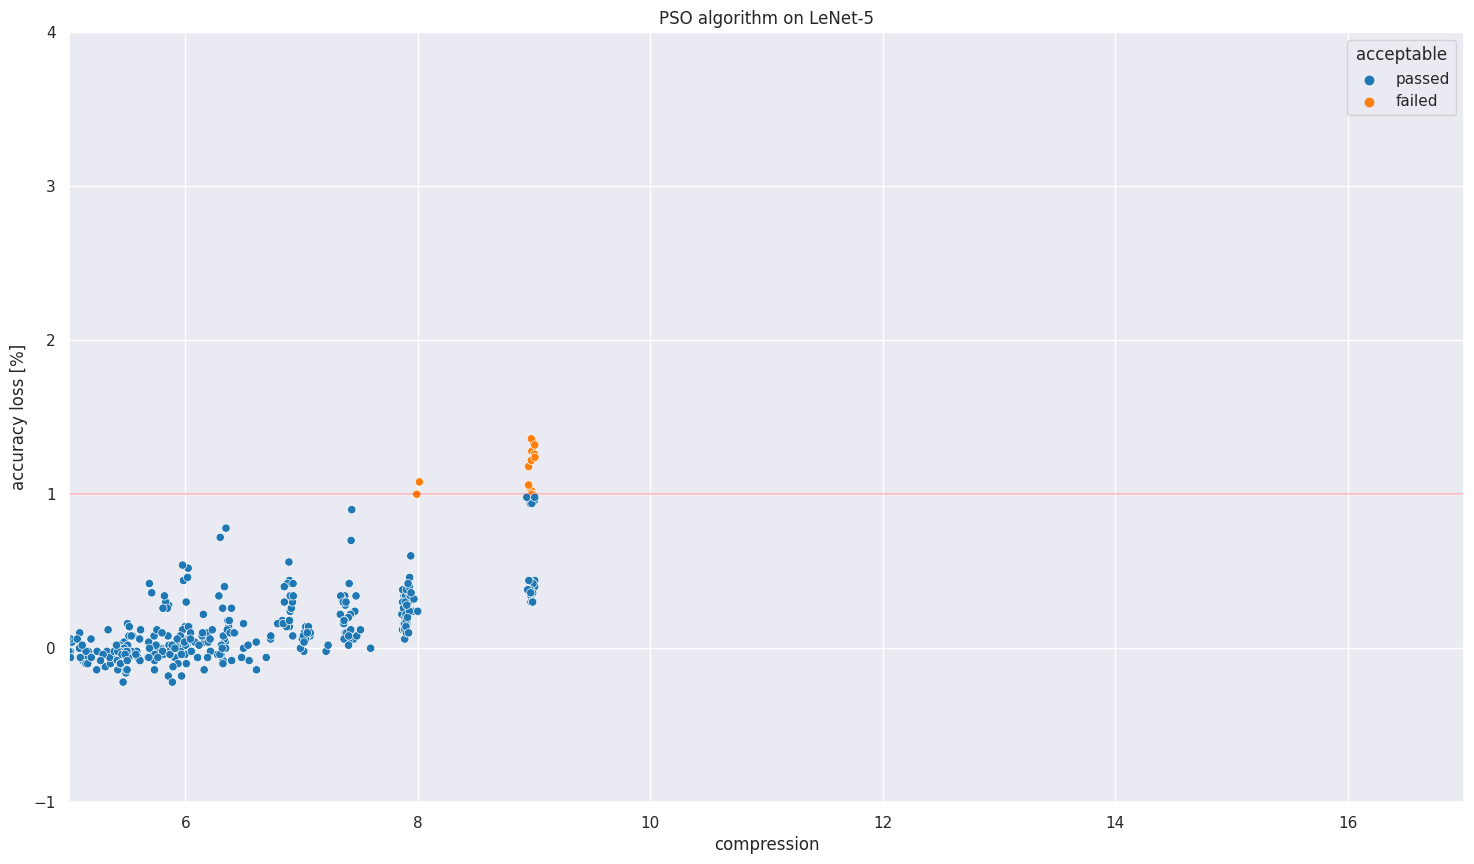

In [10]:
plot_alcr(pso_data)
plt.title('PSO algorithm on LeNet-5')